In [2]:
import pandas as pd

In [3]:
import matplotlib.pyplot as plt

In [4]:
df = pd.read_csv("Instagram_advertising_dataset.csv")

In [5]:
df.shape
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21692 entries, 0 to 21691
Columns: 164 entries, Impressions to id0129
dtypes: float64(50), int64(111), object(3)
memory usage: 27.1+ MB


In [6]:
df.columns

Index(['Impressions', 'Clicks', 'CTR', 'CTR_log', 'Caption_masked', 'Start',
       'End', 'WC', 'affect', 'posemo',
       ...
       'id0118', 'id0119', 'id0120', 'id0121', 'id0122', 'id0123', 'id0124',
       'id0127', 'id0128', 'id0129'],
      dtype='object', length=164)

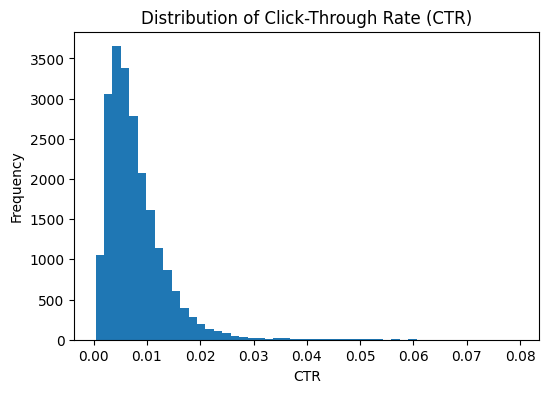

In [7]:
plt.figure(figsize=(6,4))
plt.hist(df["CTR"], bins=50)
plt.xlabel("CTR")
plt.ylabel("Frequency")
plt.title("Distribution of Click-Through Rate (CTR)")
plt.show()

In [8]:
df["Start"] = pd.to_datetime(df["Start"])
df["End"] = pd.to_datetime(df["End"])

df["campaign_days"] = (df["End"] - df["Start"]).dt.days

In [9]:
df[["Start", "End", "campaign_days"]].head()

,Start,End,campaign_days
0,2021-01-12,2021-01-14,2
1,2021-02-04,2021-02-05,1
2,2020-11-17,2020-11-18,1
3,2021-02-19,2021-02-23,4
4,2021-02-19,2021-02-20,1


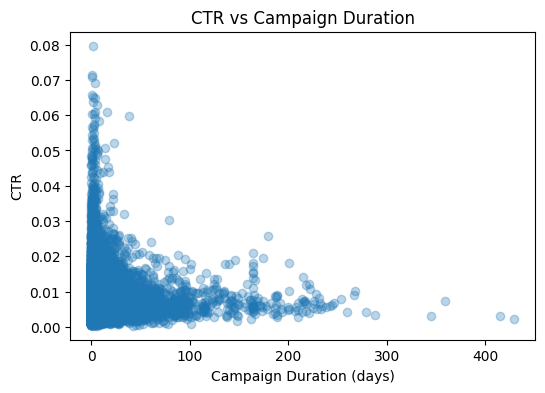

In [10]:
plt.figure(figsize=(6,4))
plt.scatter(df["campaign_days"], df["CTR"], alpha=0.3)
plt.xlabel("Campaign Duration (days)")
plt.ylabel("CTR")
plt.title("CTR vs Campaign Duration")
plt.show()

### CTR and Campaign Duration
The scatter plot illustrates the relationship between campaign duration and CTR. While CTR values vary across campaigns of different lengths, a general tendency towards lower CTR values is observed as campaign duration increases. This suggests that prolonged exposure may be associated with declining performance, motivating further analysis of creative fatigue using temporal decay patterns.

In [11]:
caption_counts = df["Caption_masked"].value_counts()

valid_captions = caption_counts[caption_counts >= 3].index

len(valid_captions)

500

In [12]:
sample_captions = valid_captions[:5]

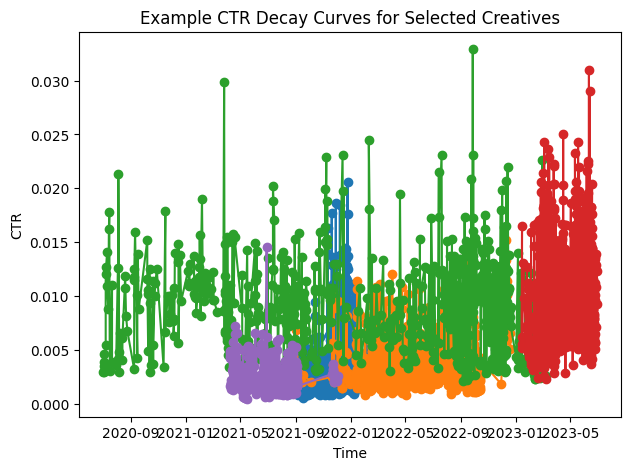

In [13]:
plt.figure(figsize=(7,5))

for cap in sample_captions:
    temp = df[df["Caption_masked"] == cap].sort_values("Start")
    plt.plot(temp["Start"], temp["CTR"], marker="o")

plt.xlabel("Time")
plt.ylabel("CTR")
plt.title("Example CTR Decay Curves for Selected Creatives")
plt.show()


### CTR Decay Patterns Across Creatives
The figure presents CTR trajectories for a sample of ad creatives deployed across multiple campaign periods. Although performance patterns vary across creatives, several exhibit an initial peak followed by a sustained decline in CTR over time. This heterogeneity and post-peak deterioration support the treatment of creative fatigue as a measurable temporal phenomenon rather than a static performance outcome.

### Fatigue Labelling Logic & Implementation

Creative fatigue is operationally defined as a sustained decline in advertising performance following a peak engagement level, despite continued exposure.

For each creative, observations are ordered chronologically and the peak click-through rate (CTR_peak) is identified.
Post-peak observations are monitored, and a creative is labelled as fatigued if its CTR declines by at least 25%~35%
from the peak value across two consecutive post-peak observations, while impressions remain stable or increase.

This rule-based labelling approach ensures reproducibility and avoids subjective manual annotation.

### Fatigue Labelling

In [14]:
df = df.sort_values(by=["Caption_masked", "Start"]).reset_index(drop=True)

In [15]:
df["fatigued"] = 0

In [16]:
test_creative = df["Caption_masked"].iloc[0]

group = df[df["Caption_masked"] == test_creative]

group[["Start", "CTR", "Impressions"]].head()

,Start,CTR,Impressions
0,2021-09-02,0.009522,12603
1,2021-09-02,0.007858,15525
2,2021-09-02,0.002917,19195
3,2021-09-10,0.009126,26956


In [17]:
ctr_peak = group["CTR"].max()
peak_row = group.loc[group["CTR"].idxmax(), ["Start", "CTR", "Impressions"]]

ctr_peak, peak_row

(np.float64(0.0095215424898833),
 Start          2021-09-02 00:00:00
 CTR                       0.009522
 Impressions                  12603
 Name: 0, dtype: object)

In [18]:
peak_idx = group["CTR"].idxmax()

post_peak = group.loc[group.index > peak_idx]

post_peak[["Start", "CTR", "Impressions"]]

,Start,CTR,Impressions
1,2021-09-02,0.007858,15525
2,2021-09-02,0.002917,19195
3,2021-09-10,0.009126,26956


In [19]:
threshold = 0.7 * ctr_peak

row_t = post_peak.iloc[0]
row_t1 = post_peak.iloc[1]

threshold, row_t[["CTR", "Impressions"]], row_t1[["CTR", "Impressions"]]

(np.float64(0.006665079742918309),
 CTR            0.007858
 Impressions       15525
 Name: 1, dtype: object,
 CTR            0.002917
 Impressions       19195
 Name: 2, dtype: object)

In [20]:
df.loc[row_t1.name, "fatigued"] = int(
    (row_t["CTR"] <= threshold) and
    (row_t1["CTR"] <= threshold) and
    (row_t1["Impressions"] >= row_t["Impressions"])
)

In [21]:
df.loc[row_t1.name, ["Start", "CTR", "Impressions", "fatigued"]]

Start          2021-09-02 00:00:00
CTR                       0.002917
Impressions                  19195
fatigued                         0
Name: 2, dtype: object

In [22]:
for creative, group in df.groupby("Caption_masked"):

    ctr_peak = group["CTR"].max()
    peak_idx = group["CTR"].idxmax()
    threshold = 0.7 * ctr_peak

    post_peak = group.loc[group.index > peak_idx]

    for i in range(len(post_peak) - 1):
        t = post_peak.iloc[i]
        t1 = post_peak.iloc[i + 1]

        if (
            t["CTR"] <= threshold and
            t1["CTR"] <= threshold and
            t1["Impressions"] >= t["Impressions"]
        ):
            df.loc[t1.name, "fatigued"] = 1

In [23]:
df["fatigued"].value_counts()

fatigued
0    17240
1     4452
Name: count, dtype: int64

In [24]:
for creative, group in df.groupby("Caption_masked"):

    ctr_peak = group["CTR"].max()
    peak_idx = group["CTR"].idxmax()
    threshold = 0.65 * ctr_peak

    post_peak = group.loc[group.index > peak_idx]

    for i in range(len(post_peak) - 1):
        t = post_peak.iloc[i]
        t1 = post_peak.iloc[i + 1]

        if (
            t["CTR"] <= threshold and
            t1["CTR"] <= threshold and
            t1["Impressions"] >= t["Impressions"]
        ):
            df.loc[t1.name, "fatigued"] = 1

df["fatigued"].value_counts()

fatigued
0    17240
1     4452
Name: count, dtype: int64

In [25]:
for creative, group in df.groupby("Caption_masked"):

    ctr_peak = group["CTR"].max()
    peak_idx = group["CTR"].idxmax()
    threshold = 0.75 * ctr_peak

    post_peak = group.loc[group.index > peak_idx]

    for i in range(len(post_peak) - 1):
        t = post_peak.iloc[i]
        t1 = post_peak.iloc[i + 1]

        if (
            t["CTR"] <= threshold and
            t1["CTR"] <= threshold and
            t1["Impressions"] >= t["Impressions"]
        ):
            df.loc[t1.name, "fatigued"] = 1

df["fatigued"].value_counts()

fatigued
0    17064
1     4628
Name: count, dtype: int64